## Prepare

In [96]:
# ! python3 -V

In [97]:
# ! pip install -r requirements.txt

In [98]:
# ! wget -O dacapo-bench.jar https://downloads.sourceforge.net/project/dacapobench/9.12-bach-MR1/dacapo-9.12-MR1-bach.jar
# ! wget -O gcviewer-1.36.jar http://sourceforge.net/projects/gcviewer/files/gcviewer-1.36.jar/download
# ! wget -O jdk.tar.gz https://download.bell-sw.com/java/11.0.20+8/bellsoft-jdk11.0.20+8-linux-amd64.tar.gz
# # MACOS
# # ! wget -O jdk.tar.gz https://download.bell-sw.com/java/11.0.20.1+1/bellsoft-jdk11.0.20.1+1-macos-amd64.tar.gz
# # ! wget -O jdk.zip https://download.bell-sw.com/java/11.0.20.1+1/bellsoft-jdk11.0.20.1+1-windows-amd64.zip
# # ! wget https://sourceforge.net/projects/gcviewer/files/gcviewer-1.36.jar/download
# ! tar xzf jdk.tar.gz && rm -fv jdk.tar.gz
# ! java -version

In [99]:
# ! ./jdk-11.0.20/bin/java -jar dacapo/dacapochopin.jar -l

In [100]:
# !  ./jdk-11.0.20/bin/java -jar dacapo-bench.jar xalan

In [101]:
# ! ./jdk-11.0.20/bin/java -XX:+UseParallelGC -Xmx4g -Xms128m  -cp dacapo-bench.jar \
# -Xlog:gc=debug:file=gc-avrora.txt -Dvmstat.enable_jfr=yes \
# -Dvmstat.csv=yes Harness -v -n 5 xalan

In [102]:
# ! pip install gym
# ! mkdir /home/ellkrauze/tmp
# ! export TMPDIR=/home/ellkrauze/tmp && pip install tensorflow
# ! export TMPDIR=/home/ellkrauze/tmp && pip install protobuf==3.20.*
# ! export TMPDIR=/home/ellkrauze/tmp && pip  install --force-reinstall -U tensorflow==2.3.0 keras keras-rl2 h5py==2.10.*


### GCViewer

In [103]:
# # Download jar from http://sourceforge.net/projects/gcviewer/files/gcviewer-1.36.jar/download
# ! java -cp gcviewer-1.36.jar com.tagtraum.perf.gcviewer.GCViewer gc-avrora.txt summary.csv -t SUMMARY

# Tensorflow DQN

In [1]:
import os
import imageio
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import reverb

from tf_agents.drivers import py_driver
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.policies import py_tf_eager_policy

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network, sequential
from tf_agents.policies import random_tf_policy, policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

# from PyEnvironments import CurveEnv, CurveMultipleEnv, JVMEnv
# from PyEnvironments import JVMEnv
from PyEnvironmentsTest import JVMEnv # !!!

# from tf_agents.environments import TimeLimit 
from tf_agents.environments.wrappers import TimeLimit 
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.reinforce import reinforce_agent

from tf_agents.specs import from_spec
# from tf_agents.trajectories import time_step_spec
from tf_agents import trajectories

2023-10-27 08:36:31.243495: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 08:36:31.278703: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 08:36:31.279628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 08:36:31.990423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 10000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

batch_size = 128  # @param {type:"integer"}
learning_rate = 1e-6
gamma = 0.9999 # The discount factor determines the importance of future rewards
gradient_clipping = 1
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 10  # @param {type:"integer"}

target_update_period = 1000

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}

train_step_counter = tf.Variable(0)
global_step = tf.compat.v1.train.get_or_create_global_step()


In [3]:
# JDK used for benchmarking
# TEST_JDK_PATH = "/Users/ellkrauze/projects/gc-ml/jdk-11.0.20.1.jdk"
TEST_JDK_PATH = "/home/vsakovskaya/gc-ml/jdk-11.0.20"

# DaCapo benchmark name
BM = "avrora"
BM_TEST = "kafka"
BM_PATH = "/home/vsakovskaya/gc-ml/dacapo/dacapochopin.jar"
CALLBACK_PATH = "/home/vsakovskaya/gc-ml/dacapo/DacapoCallback/DacapoChopin/VMStatCallback.java"

# =================
dataset_path = "dataset/data"
tempdir = "tmp"
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
policy_dir = os.path.join(tempdir, 'policy')
# =================

env = JVMEnv(
    jdk=TEST_JDK_PATH, 
    bm_path=BM_PATH, 
    callback_path=CALLBACK_PATH,
    bm=BM, 
    verbose=True
)

env_test = JVMEnv(
        jdk=TEST_JDK_PATH, 
        bm_path=BM_PATH, 
        callback_path=CALLBACK_PATH,
        bm=BM_TEST,
        verbose=True
    )

# train_env = tf_py_environment.TFPyEnvironment(env, isolation=True)
# eval_env = tf_py_environment.TFPyEnvironment(env, isolation=True)
# test_env = tf_py_environment.TFPyEnvironment(env_test)

## Add wrapper: End episodes after specified number of steps
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/environments/TimeLimit

max_steps = 10

train_env = TimeLimit(env, duration=max_steps)
eval_env = TimeLimit(env, duration=max_steps)
test_env = TimeLimit(env_test, duration=max_steps)

Successfully initialized a JVM Environment!
 JDK: /home/vsakovskaya/gc-ml/jdk-11.0.20/bin,
 Benchmark: avrora (/home/vsakovskaya/gc-ml/dacapo/dacapochopin.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.47],
 Env. default goal value: 0.47,

Successfully initialized a JVM Environment!
 JDK: /home/vsakovskaya/gc-ml/jdk-11.0.20/bin,
 Benchmark: kafka (/home/vsakovskaya/gc-ml/dacapo/dacapochopin.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.34],
 Env. default goal value: 0.34,



In [4]:
action_spec = from_spec(train_env.action_spec())
observation_spec = from_spec(train_env.observation_spec())
reward_spec = from_spec(train_env.reward_spec())
# time_step_spec = train_env.time_step_spec()
time_step_spec = trajectories.time_step_spec(observation_spec, reward_spec)

fc_layer_params = (100, 75, 50)

actor_net = actor_distribution_network.ActorDistributionNetwork(
    observation_spec,
    action_spec,
    fc_layer_params=fc_layer_params)


In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = reinforce_agent.ReinforceAgent(
    time_step_spec,
    action_spec,
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
agent.initialize()

random_policy = random_tf_policy.RandomTFPolicy(
  time_step_spec = time_step_spec,
  action_spec = action_spec,
  automatic_state_reset=True,
  clip=False
)

In [6]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=batch_size,
    max_length=replay_buffer_capacity)

tf_policy_saver = policy_saver.PolicySaver(agent.policy)
replay_buffer_observer = replay_buffer.add_batch
trajectories = []

### [Optional] Visualize Dataset

In [111]:
x = []
y = []
pairs = []
rews = []
for each in trajectories:
    pairs.append(each[0].numpy()[0])
    x.append(each[0][0][0].numpy())
    y.append(each[0][0][1].numpy())
    rews.append(each[1])
    # print(each[1])

# rewards_df = pd.DataFrame(pairs, rews, columns=["MaxTenuringThreshold", "ParallelGCThreads"])
# rewards_df = rewards_df.reset_index()
# rewards_df = rewards_df.rename(columns={'index': 'reward'})

# rewards_df.sort_values(by='reward', ascending=False)

<Axes: title={'center': 'Frequency of flag pairs in a dataset'}, xlabel='MaxTenuringThreshold,ParallelGCThreads'>

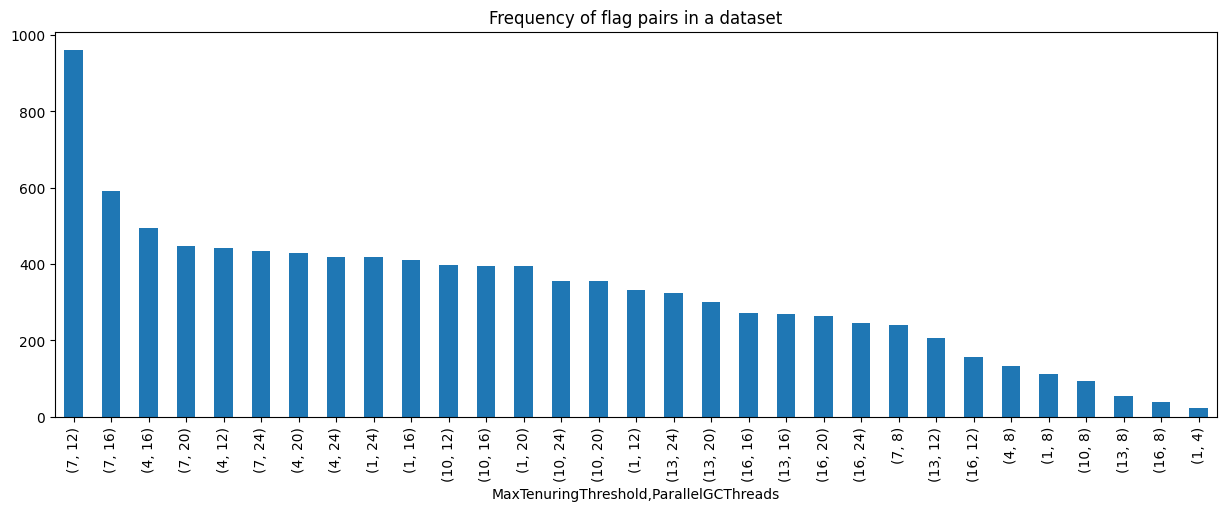

In [112]:
import pandas as pd

df = pd.DataFrame(pairs, columns=["MaxTenuringThreshold", "ParallelGCThreads"])
df.value_counts().head(100).plot(figsize=(15,5), kind='bar', title="Frequency of flag pairs in a dataset")

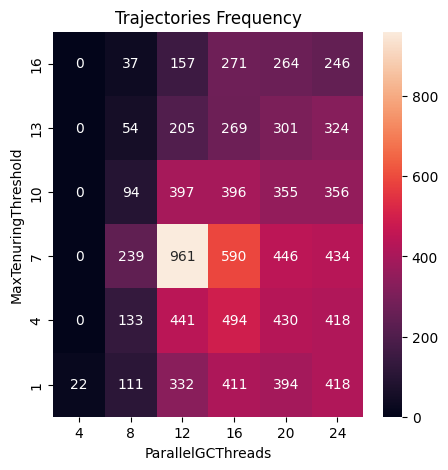

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(5, 5))
x = df.pivot_table(index='MaxTenuringThreshold',columns='ParallelGCThreads',aggfunc='size',fill_value=0)
idx = x.max(axis=1).sort_values(ascending=0).index
sns.heatmap(x, annot=True, ax=ax, fmt="")
ax.set_title("Trajectories Frequency")
ax.invert_yaxis()
plt.show()

Plot data as heatmap.

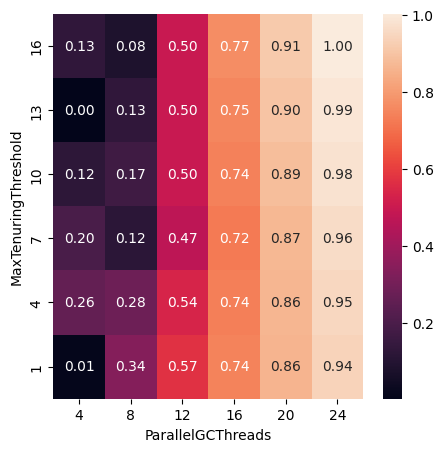

In [114]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
cached_states = env._perf_states
X = [cached_states[i]["args"][0] for i in cached_states.keys()]
Y = [cached_states[i]["args"][1] for i in cached_states.keys()]
Z = [cached_states[i]["goal"] for i in cached_states.keys()]

data = pd.DataFrame({'MaxTenuringThreshold': X, 'ParallelGCThreads': Y, 'Average GC Pause': Z})
data_pivoted = data.pivot("MaxTenuringThreshold", "ParallelGCThreads", "Average GC Pause")
ax = sns.heatmap(data_pivoted, annot=True, ax=ax, fmt=".2f")
ax.invert_yaxis()
plt.show()

## Agent Training

In [7]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
      replay_buffer_signature)
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=None,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpvtomh1dz.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpvtomh1dz
[reverb/cc/platform/default/server.cc:71] Started replay server on port 41519


In [8]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    
    # print(f"episode return: {episode_return}")
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return
  # return avg_return.numpy()[0]


def collect_episode(environment, policy, num_episodes):
  driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(
      policy, use_tf_function=True),
    [rb_observer],
    max_episodes=num_episodes)
  initial_time_step = environment.reset()
  driver.run(initial_time_step)


In [ ]:

agent.train = common.function(agent.train)
# Reset the train step
agent.train_step_counter.assign(0)
agent.initialize()

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, 100)
returns = [avg_return]

loss = []
returns = []
collect_episodes_per_iteration = 2 

for _ in range(num_iterations):
# for _ in range(1000):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_env, agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  iterator = iter(replay_buffer.as_dataset(sample_batch_size=1))
  trajectories, _ = next(iterator)
  train_loss = agent.train(experience=trajectories)  

  replay_buffer.clear()

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

### WandB

In [ ]:
! export WANDB_NOTEBOOK_NAME="main.ipynb"
import wandb

WANDB_KEY = "4b077df3688052b0f43705d6b4d712c05fb979b7"
config = dict(
    competition = 'GC ML',
    _wandb_kernel = 'lemon',
    seed = 42,
)

In [ ]:
# Set this to True when you want to run hyperparameter tuning
hyperparameter_tuning = True

def train_agent():
    run = wandb.init(config = config)
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=run.config.learning_rate)

    train_step_counter = tf.Variable(0)

    agent = reinforce_agent.ReinforceAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        optimizer=optimizer,
        normalize_returns=True,
        train_step_counter=train_step_counter,
        gamma=run.config.gamma,
    )
    agent.initialize()

# Define sweep config
sweep_configuration = {
    'method': 'random',
    'name': 'rl_greed',
    "metric": {
        "name" : "loss",
        "goal": "minimize"
    },
    "parameters" : {
        "learning_rate": {
            "min": 0.001,
            "max": 0.01
        },
        
    },
    'run_cap' : 32
}

if hyperparameter_tuning:
    # Initialize sweep by passing in config. (Optional) Provide a name of the project.
    sweep_id = wandb.sweep(sweep=sweep_configuration, project="Predicting-City-Status-Task",)

    # Start sweep job.
    wandb.agent(sweep_id, function=train_agent)